In [5]:
import requests
import shapely
import time
import json
import geopandas as gpd
import h3
import numpy as np
from matplotlib import pyplot as plt
root_url = 'http://localhost:8454/dggs-api/v1-pre'

In [6]:
aoi = [[23.08263459505376, 62.920455504767205],
          [23.08263459505376, 60.026683622641926],
          [27.21349397005376, 60.026683622641926],
          [27.21349397005376, 62.920455504767205]]
aoi = shapely.Polygon(aoi)

In [18]:
vh3_zonesId = requests.get(f'{root_url}/dggs/VH3_2_IGEO7/zones',params={'bbox':aoi.bounds, 'compact_zone':False, 'zone_level':4})
igeo7_zonesId = requests.get(f'{root_url}/dggs/IGEO7/zones',params={'bbox':aoi.bounds, 'compact_zone':False, 'zone_level':6})
h3_zonesId = h3.h3shape_to_cells(h3.geo_to_h3shape(shapely.box(*aoi.bounds)), 4)

In [19]:
#vh3_zonesId = vh3_zonesId.json()['zones']
igeo7_zonesId = igeo7_zonesId.json()
print(igeo7_zonesId)

{'zones': ['00010042', '00010040', '00010044', '00010046', '00010423', '00010422', '00010615', '00010610', '00010611', '00010616', '00010604', '00010641', '00010605', '00010652', '00010656', '00010654', '00010650', '00010655', '00010651', '00010653', '00010614', '00010426', '00010424', '00010461', '00010463', '00010462', '00014331', '00010466', '00010460', '00010464', '00014313', '00014311', '00010442', '00010443', '00010465', '00010406', '00010404', '00010405', '00010400', '00010402', '00010420', '00010421', '00010425', '00010403', '00010436', '00010432', '00010412', '00010434', '00010401', '00010416', '00010414', '00010451', '00010453', '00010452', '00010450', '00010455', '00010454', '00015262', '00015263', '00015226', '00015261', '00015265', '00015206', '00015243', '00015242', '00015240', '00015246', '00014111', '00015264', '00015260', '00015266', '00014135', '00014112', '00014113', '00014115', '00014114', '00014110', '00014116', '00014153', '00014105', '00014101', '00014134', '0001

In [ ]:
s=time.time()
feature = []
for zoneid in vh3_zonesId:
    r = requests.get(f'{root_url}/dggs/VH3_2_IGEO7/zones/{zoneid}/data',{'depth':2},headers={'accept':'application/geo+json'})
    assert r.status_code == 200
    feature += r.json()['features']
print(time.time()-s)
print(len(feature))

In [9]:
s=time.time()
igeo7_feature = []
for zoneid in igeo7_zonesId:
    r = requests.get(f'{root_url}/dggs/IGEO7/zones/{zoneid}/data',{'depth':1},headers={'accept':'application/geo+json'})
    assert r.status_code == 200
    igeo7_feature += r.json()['features']
print(time.time()-s)
print(len(igeo7_feature))

12.257425308227539
2399


In [ ]:
vh3_geometry= [shapely.from_geojson(json.dumps(f['geometry'])) for f in feature]
vh3_data = [list(f['properties'].values()) for f in feature]
vh3_gdf = gpd.GeoDataFrame(vh3_data, geometry=vh3_geometry, crs='wgs84', columns=list(feature[0]['properties'].keys()))

In [10]:
igeo7_geometry= [shapely.from_geojson(json.dumps(f['geometry'])) for f in igeo7_feature]
igeo7_data = [list(f['properties'].values()) for f in igeo7_feature]
igeo7_gdf = gpd.GeoDataFrame(igeo7_data, geometry=igeo7_geometry, crs='wgs84', columns=list(igeo7_feature[0]['properties'].keys()))
igeo7_gdf_unique = igeo7_gdf.drop_duplicates('zoneId')

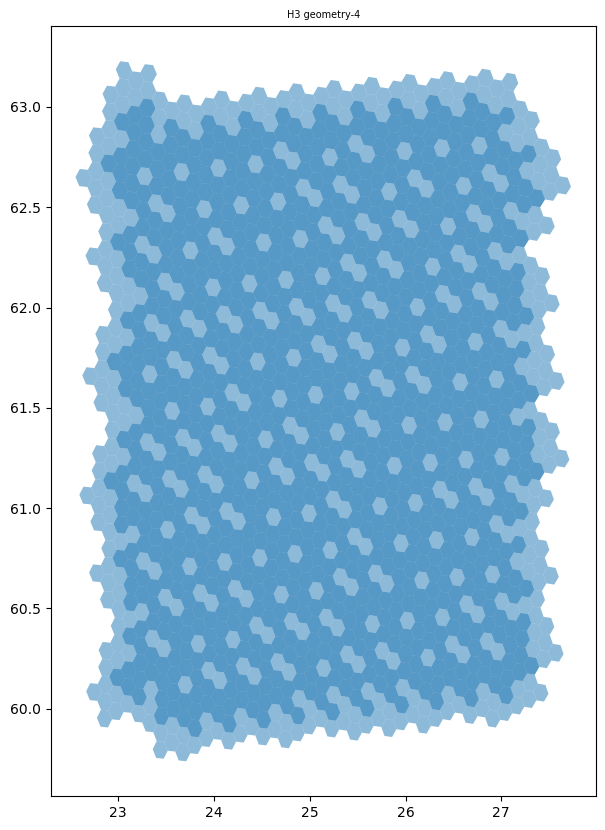

In [12]:
fig, ax =plt.subplots(1,1,figsize=(10,10))
ax.set_title('Coverage Comparison (VH3-6 vs IGEO7-7)',size=7)
ax.set_title('H3 geometry-4',size=7)
#vh3_gdf.plot(ax=ax, facecolor='green')
igeo7_gdf.plot(ax=ax, alpha=0.5)
h3_geo=gpd.GeoDataFrame([0], geometry=[shapely.from_geojson(json.dumps(h3.h3shape_to_geo(h3.cells_to_h3shape(h3_zonesId))))], crs="wgs84")
#h3_geo.plot(ax=ax[1])

In [ ]:
h = len(vh3_gdf.columns)-2
columns = ['suitability_hytruck.modelled_fuel_stations',
       'suitability_hytruck.modelled_seashore',
       'suitability_hytruck.modelled_solar_wind',
       'suitability_hytruck.modelled_urban_nodes',
       'suitability_hytruck.modelled_water_bodies',
       'suitability_hytruck.modelled_gas_pipelines',
       'suitability_hytruck.modelled_hydrogen_pipelines',
       'suitability_hytruck.modelled_corridor_points',
       'suitability_hytruck.modelled_powerlines',
       'suitability_hytruck.modelled_transport_nodes',
       'suitability_hytruck.modelled_residential_areas',
       'suitability_hytruck.modelled_rest_areas',
       'suitability_hytruck.modelled_slope']
fig, ax =plt.subplots(h,2,figsize=(100,100), layout='tight')
for i, c in enumerate(columns):
    if (c != 'zoneId' and c!= 'geometry'):
        ax[i][0].set_title(f'VH3-6 :{c}',size=10)
        ax[i][1].set_title(f'IGEO7-7 :{c}',size=10)
        vh3_gdf.plot(ax=ax[i][0], column=c)
        igeo7_gdf_unique.plot(ax=ax[i][1], column=c)
plt.tight_layout()